# Text Classification with Bag of Words

## Download and Extract the Data

In [138]:
import os

In [143]:
IS_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ
DATA_DIR = "/kaggle/input/quora-insincere-questions-classification" if IS_KAGGLE else "../data/quora-insincere-questions-classification"

In [145]:
if not IS_KAGGLE:
	!kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p ../data/quora-insincere-questions-classification
	!kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p ../data/quora-insincere-questions-classification
	!kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p ../data/quora-insincere-questions-classification

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [144]:
train_fname = DATA_DIR + "/train.csv.zip"
test_fname = DATA_DIR + "/test.csv.zip"
sample_fname = DATA_DIR + "/sample_submission.csv.zip"

In [10]:
import pandas as pd

In [23]:
raw_df = pd.read_csv(train_fname)
raw_df.sample(5)

,qid,question_text,target
946979,b98fdec3b05eca18eb82,What is the best way to learn dance?,0
549136,6b9460b5c03a8d70628d,How many fashion colleges are there in India?,0
44716,08c0ec5358c7255de5ea,Why do Montreal and Quebec endorse gang stalking?,1
334598,4192308a2a6fe41b3729,How well did the Chinese defend China during WW2?,0
143129,1c02813f1d87088d2350,What things can Google not answer?,0


In [15]:
sincere_df = raw_df[raw_df["target"] == 0]
sincere_df.sample(5)

,qid,question_text,target
89453,118822786fceb6cc5877,How is it possible to have zero gravity at the...,0
626109,7a9bfd266db1c73dfde6,Are there situations in which firing an employ...,0
442175,56a6e471d273d493b954,How important are chromosomal markers in predi...,0
570326,6fbf9fd0022cd953e58c,What do you like and dislike about Fox News' T...,0
36566,0726a2c55037adf076b5,Should I have a lower jaw surgery?,0


In [16]:
insincere_df = raw_df[raw_df["target"] == 1]
insincere_df.sample(5)

,qid,question_text,target
1007699,c576d4767885521f267a,Why did the Nobel Prizes begin to become worth...,1
252176,315a7e87431a8f430f48,Since there is no chance of recovery from Bord...,1
168474,20ec6e2d13db0e77842e,What other places in Australia start with A to Z?,1
254243,31c10a3f4ae996b87f94,Why is my son's stupid bangal cat always peein...,1
943124,b8d3f97c17900c57a8de,Hillary Clinton doesn't really write her answe...,1


<Axes: xlabel='target'>

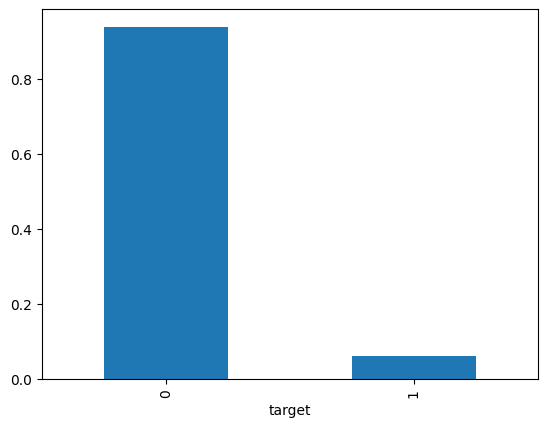

In [26]:
raw_df.target.value_counts(normalize=True).plot(kind="bar")

In [27]:
test_df = pd.read_csv(test_fname)
test_df.sample(5)

,qid,question_text
295233,c9086513f56a10a88bea,How can one test his IQ in a practical life?
230969,9d2953a2dac6b82d68f5,What particles get collided to make a strange ...
191911,8287fd2ff0dd742eaba0,Are there any successful SaaS banking platform...
159739,6cb8ce22ffc3c8997272,Why did Palestine still claim Jerusalem which ...
80032,365c5dd36571dabaf8e6,Which node in the atomic orbital passes throug...


In [28]:
sub_df = pd.read_csv(sample_fname)
sub_df.sample(5)

,qid,prediction
258403,afe4a20b349547e9656c,0
56457,266d32f07ab0d9e1962b,0
122681,5375b0d4883b1acb6ac8,0
353991,f1472a6c855422d64ed1,0
317277,d80b75c2330c0b9502b5,0


In [29]:
SAMPLE_SIZE = 100_000

In [31]:
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
sample_df

,qid,question_text,target
443046,56d324bb1e2c29f43b12,What is the most effective classroom managemen...,0
947549,b9ad893dc78c577f8a63,Can I study abroad after 10th class from Bangl...,0
523769,6689ebaeeb65b209a412,How can I make friends as a college junior?,0
949821,ba1e2c4a0fef09671516,How do I download free APK Minecraft: Pocket E...,0
1030397,c9ea2b69bf0d74626f46,"Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
998930,c3c03a307a29c69971b4,How do I research list of reliable charcoal im...,0
66641,0d119aba95ee6684f506,"What are petroleum products, and what is petro...",0
90024,11a46cd148a104b271cf,What are some services that will let you quick...,0
130113,1973e6e2111a0c93193a,What credit card processors do online marketpl...,0


## Text Preprocessing Techniques

### Bag of Words Intuition

1. Create a list of all the words across all the documents.
2. Convert each document into vector counts of the words in the list.

**Limitations:**
1. There may be too many words in the dataset (vector will be too large).
2. Some words may occur very frequently and dominate the vector representation.
3. Some words may occur very infrequently and may not contribute much to the vector representation.
4. A single word may have multiple forms (e.g. run, running, ran).

So we need to do some preprocessing techniques to overcome these limitations.

In [32]:
q0 = sincere_df.question_text.sample(1).iloc[0]
q0

'Is GDPR the first step in creating a massive centralized EU citizen database?'

In [33]:
q1 = insincere_df.question_text.sample(1).iloc[0]
q1

'Why do all the people from Kannur in Kerala love Mangalore very much, but all the Kannadigas from Karnataka hate Mangalore and its people?'

### Tokenization

Split the text into words and separators.

In [34]:
from nltk.tokenize import word_tokenize

In [36]:
q0_tokens = word_tokenize(q0)
q1_tokens = word_tokenize(q1)

### Stop Word Removal

Remove common words that will likely appear in any text.

In [38]:
from nltk.corpus import stopwords

In [41]:
english_stopwords = set(stopwords.words("english"))

In [42]:
def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in english_stopwords]

In [45]:
q0_stp = remove_stopwords(q0_tokens)
q1_stp = remove_stopwords(q1_tokens)

### Stemming

Reduce a word to its base/stem form. For example, running, ran, runs all reduce to run.

In [49]:
from nltk.stem import SnowballStemmer

In [55]:
stemmer = SnowballStemmer(language="english")

In [57]:
q0_stm = [stemmer.stem(t) for t in q0_stp]
q1_stm = [stemmer.stem(t) for t in q1_stp]

### Lemmatization

Similar to stemming, but reduces words to their base forms using a dictionary.

**When to use stemming and when to use lemmatization?**

Use stemming when meaning of words are not important for analysis. Use lemmatization when meaning of words are important for analysis. For example, in search engines, stemming is used to increase the search performance. In chatbots, lemmatization is used to understand the meaning of the words.

In the bag of words model, we will use stemming because we will turn the words into vectors and the meaning of the words is not important for the model.

## Implementing Bag of Words

1. Create a vocabulary using Count Vectorizer.
2. Transform text to word count vectors with Count Vectorizer.
3. Configure text preprocessing in Count Vectorizer.

### Create a Vocabulary

In [59]:
small_df = sample_df.sample(5, random_state=42)
small_df.question_text.values

array(['How do you make a good homemade longbow for hunting?',
       "Will my summer internship offer get rescinded for not meeting minimum cumulative GPA requirement? I've signed the contract and my major GPA meets the requirement. I've been raising my GPA the past semesters. Should I talk to HR about my situation?",
       'What would be your three dying wishes? Why? How?',
       'How would you describe the different techniques used to make illuminated manuscripts?',
       'What is the difference between cartridge and cylinder?'],
      dtype=object)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

In [63]:
small_vectorizer = CountVectorizer()
small_vectorizer.fit(small_df.question_text)
small_vectorizer.get_feature_names_out()

array(['about', 'and', 'be', 'been', 'between', 'cartridge', 'contract',
       'cumulative', 'cylinder', 'describe', 'difference', 'different',
       'do', 'dying', 'for', 'get', 'good', 'gpa', 'homemade', 'how',
       'hr', 'hunting', 'illuminated', 'internship', 'is', 'longbow',
       'major', 'make', 'manuscripts', 'meeting', 'meets', 'minimum',
       'my', 'not', 'offer', 'past', 'raising', 'requirement',
       'rescinded', 'semesters', 'should', 'signed', 'situation',
       'summer', 'talk', 'techniques', 'the', 'three', 'to', 'used', 've',
       'what', 'why', 'will', 'wishes', 'would', 'you', 'your'],
      dtype=object)

### Transform documents to word count vectors

In [66]:
vect = small_vectorizer.transform(small_df.question_text)
vect.shape

(5, 58)

### Configure Text Preprocessing in Count Vectorizer

In [68]:
stemmer = SnowballStemmer(language="english")

In [72]:
def tokenize(text):
    return [stemmer.stem(t) for t in word_tokenize(text)]

In [77]:
vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=list(english_stopwords),
    max_features=1000,
)

In [78]:
vectorizer.fit(sample_df.question_text)

/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['does', 'after', 's', 'you', "won't", 'have', 'out',
                            'any', "shan't", 'has', 'didn', "wasn't", 'did',
                            'y', 'yourselves', 'down', 'because', 'at', 'about',
                            'such', 'our', 'so', "weren't", 'shouldn', 'why',
                            're', 'him', "hasn't", 'into', 'same', ...],
                tokenizer=<function tokenize at 0x37eabd760>)

In [81]:
len(vectorizer.vocabulary_)

1000

In [83]:
vectorizer.get_feature_names_out()[:100]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '4', '5', '6', '7', '8', ':', '?', '[', ']', '``', 'abl',
       'abroad', 'abus', 'accept', 'access', 'accomplish', 'accord',
       'account', 'achiev', 'act', 'action', 'activ', 'actor', 'actual',
       'ad', 'add', 'address', 'admiss', 'adult', 'advanc', 'advantag',
       'advic', 'affect', 'africa', 'african', 'age', 'agre', 'air',
       'allow', 'almost', 'alon', 'alreadi', 'also', 'altern', 'alway',
       'amazon', 'america', 'american', 'amount', 'analysi', 'android',
       'ani', 'anim', 'anoth', 'answer', 'anxieti', 'anyon', 'anyth',
       'apart', 'app', 'appear', 'appl', 'appli', 'applic', 'approach',
       'arab', 'area', 'armi', 'around', 'art', 'asian', 'ask', 'associ',
       'atheist', 'attack', 'attend'], dtype=object)

In [86]:
inputs = vectorizer.transform(sample_df.question_text)

In [87]:
inputs.shape

(100000, 1000)

In [88]:
test_inputs = vectorizer.transform(test_df.question_text)

## ML Model for Text Classification

1. Create a training & validation set.
2. Train a logistic regression model.
3. Make predictions on the validation set.

### Create a Training & Validation Set

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs, sample_df.target, test_size=0.3, random_state=42
)

In [91]:
train_inputs.shape, val_inputs.shape

((70000, 1000), (30000, 1000))

### Train a Logistic Regression Model

In [94]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import classification_report

In [98]:
MAX_ITER = 1000

In [105]:
model = LR(
    max_iter=MAX_ITER,
    solver="sag",
    n_jobs=-1,
).fit(train_inputs, train_targets)

/Users/macbook/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [107]:
print(classification_report(val_targets, model.predict(val_inputs)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28178
           1       0.63      0.30      0.41      1822

    accuracy                           0.95     30000
   macro avg       0.79      0.65      0.69     30000
weighted avg       0.94      0.95      0.94     30000



In [111]:
train_preds = model.predict(train_inputs)
pd.Series(train_preds).value_counts(normalize=True)

0    0.970814
1    0.029186
Name: proportion, dtype: float64

In [112]:
pd.Series(train_targets).value_counts(normalize=True)

target
0    0.939771
1    0.060229
Name: proportion, dtype: float64

In [117]:
from sklearn.metrics import f1_score

In [120]:
f1_score(train_targets, train_preds)

0.4457581083240134

In [121]:
val_preds = model.predict(val_inputs)

In [122]:
f1_score(val_targets, val_preds)

0.40843507214206437

In [124]:
sincere_df.question_text.values[:10]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
       'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something g

In [123]:
model.predict(vectorizer.transform(sincere_df.question_text.values[:10]))

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [125]:
insincere_df.question_text.values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

In [126]:
model.predict(vectorizer.transform(insincere_df.question_text.values[:10]))

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0])

## Make Predictions and Submit to Kaggle

In [128]:
test_inputs.shape

(375806, 1000)

In [129]:
test_preds = model.predict(test_inputs)

In [131]:
sub_df.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [132]:
sub_df.prediction = test_preds
sub_df.prediction.value_counts()

prediction
0    364964
1     10842
Name: count, dtype: int64

In [133]:
sub_df.to_csv(DATA_DIR + "/submission.csv", index=False)

In [134]:
!head ../data/quora-insincere-questions-classification/submission.csv

qid,prediction
0000163e3ea7c7a74cd7,0
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,0
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,0
